In [1]:
import pandas as pd
import numpy as np
import eda
import visualization as viz
import feature_engineering as fe
import process_data as pr
import modeling as md

from sklearn.model_selection import StratifiedKFold, cross_val_score, RepeatedStratifiedKFold
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import seaborn as sns

model_number = 'catboost_domain_features'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

df_train.sample(3)

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
1660,1660,A,202.92,material_7,material_8,9,5,18,3,6,19.208,12.807,16.545,16.328,10.973,20.195,13.594,17.417,15.880,13.665,14.457,14.079,12.824,NaN,721.682,0
21863,21863,E,67.78,material_7,material_6,6,9,3,16,0,18.548,12.095,17.839,17.085,11.504,19.145,11.290,13.937,18.560,11.093,13.954,15.963,15.675,NaN,742.212,0
15244,15244,C,93.43,material_7,material_8,5,8,3,7,2,15.843,11.742,18.012,17.438,12.420,19.320,10.216,14.682,21.613,14.722,NaN,NaN,13.628,15.589,758.846,0


In [3]:
# Drop the id columns
dropped_columns = ['id', 'product_code']

df_train_model = df_train.drop(dropped_columns, axis=1)
df_test_model = df_test.drop(dropped_columns, axis=1)

# Assign train and test for X and y
X_train = df_train_model.drop('failure', axis=1)
y_train = df_train_model['failure']

X_test = df_test_model.copy()

In [4]:
cat_features = ['attribute_0', 'attribute_1', 'attribute_2', 'attribute_3']
continous_features = [cat for cat in X_train.columns if cat not in cat_features]
numerical_features = X_train.select_dtypes(include=['int', 'float']).columns

In [5]:
si = SimpleImputer(strategy='mean')
# Apply preprocessing to the training data
X_train_transformed = si.fit_transform(X_train[continous_features])
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train[continous_features].columns)
X_train = pd.concat([X_train[cat_features], X_train_transformed], axis=1)

X_test_transformed = si.transform(X_test[continous_features])
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test[continous_features].columns)
X_test = pd.concat([X_test[cat_features], X_test_transformed], axis=1)

X_train.head()

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,material_7,material_8,9,5,80.10,7.0,8.0,4.0,18.040,12.518,15.748,19.292,11.739,20.155,10.672,15.859,17.594000,15.193,15.029,16.048444,13.034,14.684,764.100
1,material_7,material_8,9,5,84.89,14.0,3.0,3.0,18.213,11.540,17.717,17.893,12.748,17.889,12.448,17.947,17.915000,11.755,14.732,15.425000,14.395,15.631,682.057
2,material_7,material_8,9,5,82.43,12.0,1.0,5.0,18.057,11.652,16.738,18.240,12.718,18.288,12.715,15.607,19.172085,13.798,16.711,18.631000,14.094,17.946,663.376
3,material_7,material_8,9,5,101.07,13.0,2.0,6.0,17.295,11.188,18.576,18.339,12.583,19.060,12.471,16.346,18.377000,10.020,15.250,15.562000,16.154,17.172,826.282
4,material_7,material_8,9,5,188.06,9.0,2.0,8.0,19.346,12.950,16.990,15.746,11.306,18.093,10.337,17.082,19.932000,12.428,16.182,12.760000,13.153,16.412,579.885


In [6]:
target = 'failure'

combined_df = pd.concat([X_train, X_test])
combined_df.sample(2)

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,measurement_7,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
18803,material_7,material_5,9,5,131.04,7.0,7.0,13.0,17.912,12.424,15.891,18.702,10.646,19.024714,10.061,16.415,18.587,12.737,16.002,15.466,13.820,16.431,747.562
348,material_5,material_6,6,4,131.08,13.0,14.0,1.0,15.669,12.465,17.958,18.588,10.285,18.839000,9.073,17.528,17.729,12.346,13.069,16.878,13.739,16.362,795.364


In [7]:
X_train, X_train_domain, combined_df_train = fe.generate_domain_features(X_train, X_train[numerical_features])
X_test, X_test_domain, combined_df_test = fe.generate_domain_features(X_test, X_test[numerical_features])

c:\Users\Adeniyi Babalola\Documents\GitHub\kaggle\kaggle_competition\data_science_kaggle_coursework\feature_engineering.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new_features[new_feature_name] = df[features[i]] / np.where(df[features[j]] == 0, 1e-6, df[features[j]])
c:\Users\Adeniyi Babalola\Documents\GitHub\kaggle\kaggle_competition\data_science_kaggle_coursework\feature_engineering.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_new_features[new_feature_name] = df[features[i]] / np.where(df[features[j]] =

In [ ]:
X_test_domain.sample(5)

In [ ]:
X_train_domain.shape

Learning rate set to 0.067421
0:	learn: 0.6678000	test: 0.6679445	best: 0.6679445 (0)	total: 198ms	remaining: 3m 17s
100:	learn: 0.4860069	test: 0.5105772	best: 0.5100724 (70)	total: 9.43s	remaining: 1m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5100723672
bestIteration = 70

Shrink model to first 71 iterations.
Learning rate set to 0.067421
0:	learn: 0.6677045	test: 0.6681431	best: 0.6681431 (0)	total: 97.3ms	remaining: 1m 37s
100:	learn: 0.4844666	test: 0.5098815	best: 0.5094478 (61)	total: 9.56s	remaining: 1m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5094477878
bestIteration = 61

Shrink model to first 62 iterations.
Learning rate set to 0.067421
0:	learn: 0.6677829	test: 0.6680924	best: 0.6680924 (0)	total: 111ms	remaining: 1m 50s
100:	learn: 0.4853790	test: 0.5116236	best: 0.5110560 (68)	total: 12.4s	remaining: 1m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5110560013
bestIteration = 68

Shri

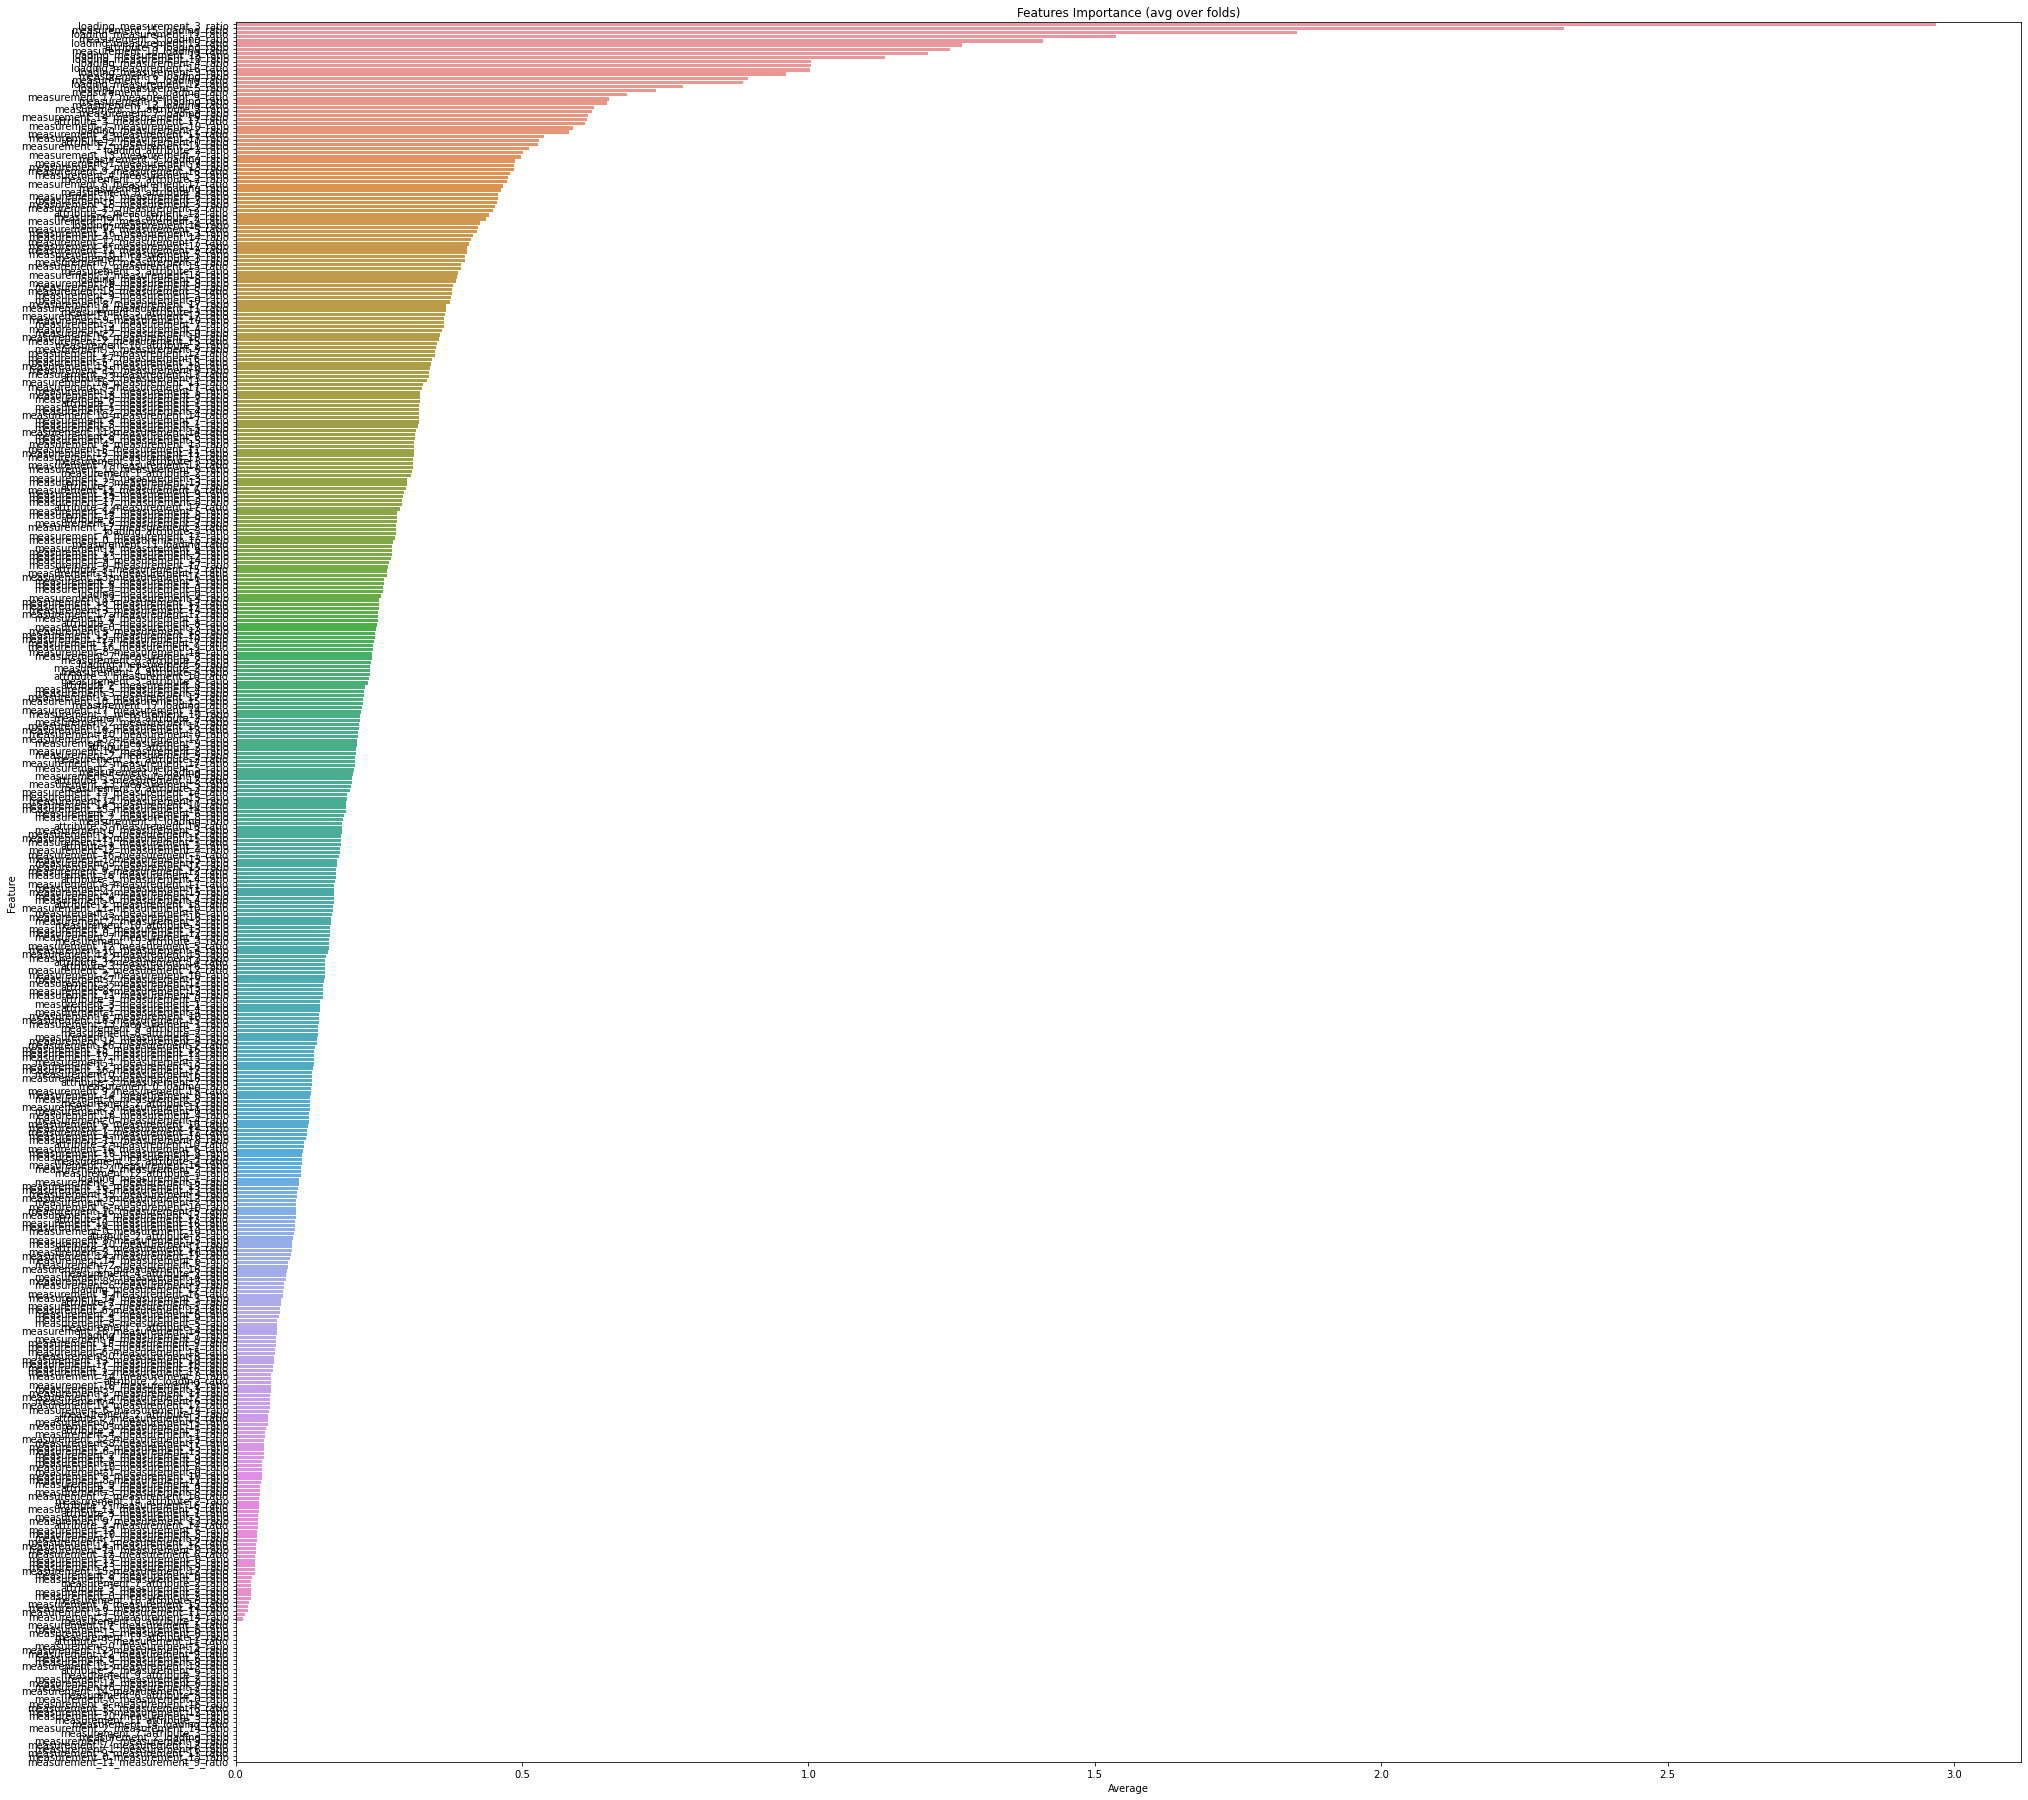

In [12]:
viz.plot_catboost_feature_importance(X_train_domain, y_train, cat_features=None, figsize=(32, 32))

In [ ]:
# Create a blank DataFrame to store the results
result_df = pd.DataFrame({'Feature': X_train_domain.columns})

In [ ]:
# Calculate the mutual information scores 5 times
for i in range(5):
    mi_scores = fe.make_mi_scores_classification(X_train_domain, y_train)
    result_df[f'Run_{i + 1}'] = mi_scores['MI Score']
    print(result_df.head(5))

In [ ]:
result_df['Average'] = result_df.iloc[:, 1:].mean(axis=1)
result_df = result_df.sort_values(by='Average', ascending=False)
result_df.to_csv(f'mi_result{model_number}.csv', index=False)
result_df.head(40)

In [ ]:
plt.figure(figsize=(32, 32))
sns.barplot(
    x=result_df['Average'],
    y=result_df['Feature'],
)

plt.title('Average MI Score')
plt.show()

In [ ]:
fi_df = pd.read_csv('feature_importance.csv')

# Merge the DataFrames on col_a
merged_df = fi_df.merge(result_df, on='Feature')

# Print the merged DataFrame
merged_df = merged_df[['Feature', 'Average_x', 'Average_y']]

merged_df['FI_MI'] = merged_df.iloc[:, 1:].mean(axis=1, skipna=True, numeric_only=True)
merged_df = merged_df.sort_values(by='FI_MI', ascending=False)
merged_df.head(40)

In [ ]:
# more_dropped_columns = ['attribute_2', 'measurement_2', 'measurement_7', 'measurement_12', 'measurement_16']
more_dropped_columns = []

# model_number = 'catboost_simpleimputer_domains'

In [ ]:
feature_list = merged_df.iloc[:25, :]['Feature'].tolist()
feature_list

In [8]:
# Initialize CatBoost model
# model = CatBoostClassifier(random_state=5, cat_features=['attribute_0', 'attribute_1','attribute_2', 'attribute_3'], verbose=False)
model = CatBoostClassifier(random_state=5, verbose=False)

In [ ]:
rfecv = RFECV(estimator=model, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

rfecv.fit(X_train_domain[feature_list], y_train)

In [ ]:
# Get the RFECV ranking of all the features to select which ones to use
# Rank 1 are the features best suited for modelling but rank 2 features aren't bad
# And so on
rfecv_features = pd.DataFrame({'Feature': list(X_test_domain[feature_list].columns),
                               'Ranking': rfecv.ranking_})

rfecv_features.sort_values(by='Ranking', inplace=True)

rfecv_features

In [ ]:
# Get the index of Rank 1 features
selected_features = [i for i, selected in enumerate(rfecv.support_) if selected]

In [ ]:
# Get a list of the rank 1 features
rfecv_rank_1 = list(X_train_domain[feature_list].columns[selected_features])
rfecv_rank_1

In [9]:
rfecv_rank_1 = ['loading_measurement_11_ratio']

In [11]:
num_folds = 5
cv = RepeatedStratifiedKFold(n_splits=num_folds, random_state=5, n_repeats=10)

# scores = cross_val_score(model, X_train.drop(dropped_columns_low_fi, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
# scores = cross_val_score(model, X_train.drop(more_dropped_columns, axis=1), y_train, cv=cv, n_jobs=-1, scoring='roc_auc')
scores = cross_val_score(model, X_train_domain[rfecv_rank_1], y_train, cv=cv, n_jobs=-1, scoring='roc_auc')

list(scores), scores.mean(), scores.std()

([0.5716514651741372,
  0.5817562479906597,
  0.5750867188954127,
  0.5661688438044636,
  0.583133597861216,
  0.5838401732112981,
  0.5744171855699758,
  0.5752910370733854,
  0.5740891343339143,
  0.5663682972639131,
  0.5920115177893972,
  0.5682142464339498,
  0.5704830030964991,
  0.5810275977596915,
  0.5624245968628911,
  0.5833420637415038,
  0.5721411318296419,
  0.5812633250985635,
  0.5809290343322222,
  0.5765641127599452,
  0.575957090837516,
  0.5706105433256062,
  0.5753790250258042,
  0.5755606059324185,
  0.5766579172236417,
  0.5649769887605255,
  0.5730723024078241,
  0.5768113673666222,
  0.5937674495338331,
  0.5671045618369177,
  0.5929946146609479,
  0.571633191762974,
  0.5705479365133082,
  0.580175214470634,
  0.5716822619672075,
  0.575995927925983,
  0.5713543164858965,
  0.5764962182101219,
  0.5795177371867544,
  0.5814845640366165,
  0.5699283471591252,
  0.5816596939034502,
  0.5722203421377687,
  0.5742656390125045,
  0.5873814489246856,
  0.57055217450

In [ ]:
# Fit the model on the entire training data
# model.fit(X_train.drop(dropped_columns_low_fi, axis=1), y_train)
model.fit(X_train_domain[rfecv_rank_1], y_train)

# Predict on the X_test data
# predictions = model.predict_proba(X_test.drop(dropped_columns_low_fi, axis=1))[:, 1]
predictions = model.predict_proba(X_test_domain[rfecv_rank_1])[:, 1]

# Create a DataFrame for submission
submission_df = pd.DataFrame(
    {'id': df_test['id'],
    'failure': predictions})

# submission_df.head(50)
# Save to CSV for submission
submission_df.to_csv(f'submission_{model_number}.csv', index=False)